In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import sys
from iminuit import Minuit
from matplotlib.colors import ListedColormap
from tqdm import tqdm
# 6.2sec

In [2]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [3]:
COLOUR = ['#1E90FF', # 0 # Dodgerblue
          '#FFBF00', # 1 # Amber
          '#FF6347', # 2 # Tomato
          '#00A86B', # 3 # Jade
          '#8A2BE2', # 4 # Blueviolet
          '#FF6FFF', # 5 # Ultra Pink
          '#00CCFF', # 6 # Vivid Sky Blue
          '#FFD800', # 7 # School Bus Yellow
          '#FF004F', # 8 # Folly
          '#0063A6', # 9 # Lapis Lazuli
        ]
def setMplParam(classNum):
    # Define effective colors, line styles, and markers based on the class number
   
    LINE = ['-', '-.', '--', '-.', ':','--','-.','-', ':', '--']
    MARKER = ['.','*', '^', 's', '.', 'p', 'o', 's', '.', 'd']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]

    # Set the color cycle for lines including color, line style, and marker
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                       plt.cycler(linestyle=LINE_EFF)+
                                       plt.cycler(marker=MARKER_EFF))

    # Set default line and marker sizes
    plt.rcParams['lines.markersize'] = 3  # Example size
    plt.rcParams['lines.linewidth'] = 2   # Example width for lines

    # Set label and title sizes
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    # Set tick properties
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20

    # Set legend font size
    plt.rcParams['legend.fontsize'] = 12

    # Enable and configure grid
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    # Set axes line width
    plt.rcParams['axes.linewidth'] = 2

    # Set tick sizes and widths
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['xtick.major.width'] = 3
    plt.rcParams['xtick.minor.size'] = 2
    plt.rcParams['xtick.minor.width'] = 2

    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['ytick.major.width'] = 3
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.minor.width'] = 2

setMplParam(10)


* Constants
  * `RADIUS` : 5,000 m
  * `RESOLUTION` : 1,000
  * unit grid width =  `RADIUS` / `RESOLUTION` m

In [4]:
RADIUS = 5000
# RESOLUTION = 1000
# lower comes first
CMAP = ['#00B7EB', '#F5F5DC'] # Process cyan & Desert sand

In [5]:
def showMap(Z, X, Y):
    fig, ax = plt.subplots(figsize = (11, 8))
    cmap = ListedColormap(CMAP)
    # Using pcolormesh; X, Y, and Z dimensions must all match.
    c = ax.pcolormesh(X, Y, Z, cmap=cmap, shading='auto')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    # plt.colorbar(c, ax=ax)
    # d = {'Resolution': RESOLUTION}
    # add_text_to_ax(0.02, 0.95, nice_string_output(d, 0), ax, fontsize=12)
    plt.show()

* RESOLUTION : radius divided by RESOLUTION for form a grid

In [6]:
def defineIsland():
    STEP = 25
    XMargin = 3500
    x = np.arange(-RADIUS, RADIUS + XMargin, STEP)
    y = np.arange(-RADIUS, RADIUS, STEP)
    scaleX = len(x)
    scaleY = len(y)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if X[i, j]**2 + Y[i, j]**2 < RADIUS**2:
                Z[i, j] = 1
    return Z, X, Y

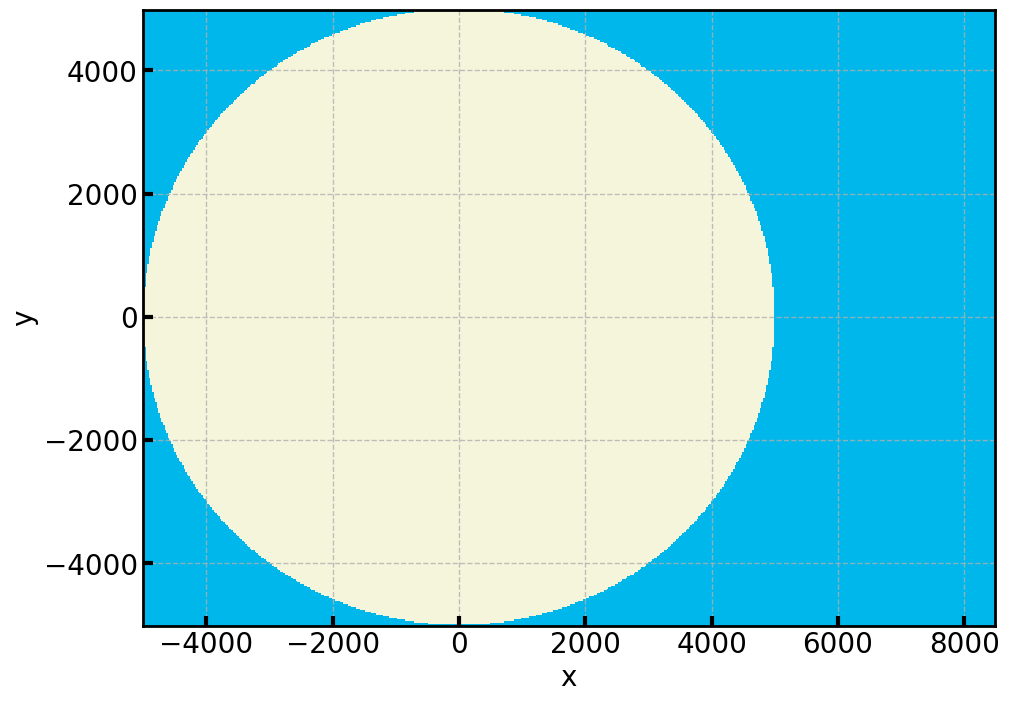

In [7]:
ISLAND, ISLAND_X, ISLAND_Y = defineIsland()
showMap(ISLAND, ISLAND_X, ISLAND_Y)

In [8]:
def getDistanceBetween(p1, p2):
    if p1 is None or p2 is None:
        return None  # or you can return some default value or raise an exception
    elif None in p1 or None in p2:  # Check if any coordinate is None
        return None
    else:
        return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def getDistanceFromCenter(position):
        return getDistanceBetween([0, 0], position)

* let's keep x, y to be the positions in the coordinate.

* daily random walk generator

In [9]:
class Crab:
    def __init__(self, position):
        self.position = position
        self.history = [position]
        self.totalTravel = 0.0
        self.hasAlreadyBeenToSea = False
        self.travelToFirstSea = 0.0
        self.dailyTravel = 0.0
        self.mass = 1.0
        self.isAlive = True

        self.merge = 0
    
    ## ------------- public getters --------------- ##
    def getPosition(self):
        return self.position
    
    def getHistory(self):
        return self.history
    
    def getTravel(self):
        return self.totalTravel
    
    def getTravelToSea(self):
        return self.travelToFirstSea
    
    def getIsAlive(self):
        return self.isAlive

    def getMass(self):
        return self.mass
    
    def getDailyTravel(self):
        return self.dailyTravel
    ## ------------- main executors --------------- ##
    def walk(self):
        p1 = self.position
        p2 = self.__dailyWalk(p1)

        self.position = p2
        self.history.append(p2)
        distance = getDistanceBetween(p1, p2)
        if distance is not None:  # Check if distance is None
            self.totalTravel += distance
            self.dailyTravel = distance
            if not self.hasAlreadyBeenToSea:
                self.travelToFirstSea += distance
    
    def eaten(self):
        infPos = None
        self.mass = 0
        self.position = [infPos, infPos]
        self.isAlive = False
    
    def devour(self, massAddtion):
        self.mass += massAddtion
        self.merge += massAddtion

    ## ------------- private handlers --------------- ##
    def __dailyWalk(self, position):
        if position == [None, None]:
            return [None, None]
        
        angle = self.__getRandomTravelAngle()
        r = self.__getRandomTravelDistance()
        # print(f'angle: {angle}, r: {r}')  # check if the angle and r are random
        
        new_P = [position[0] + r * np.cos(angle), position[1] + r * np.sin(angle)]

        if not self.__isThisPostionInIsland(new_P):
            r_toEdge = self.__howFarCanYouGet(position, new_P)
            new_P = [position[0] + r_toEdge * np.cos(angle), position[1] + r_toEdge * np.sin(angle)]
            self.hasAlreadyBeenToSea = True
        return new_P
    # geometry
    def __howFarCanYouGet(self, p1, p2):
        d1 = getDistanceFromCenter(p1)
        d2 = getDistanceFromCenter(p2)
        l = getDistanceBetween(p1, p2)
        includedAngle = np.arccos((d1**2 + d2**2 - l**2)/(2*d1*d2))

        triangleArea = 0.5 * d1 * d2 * np.sin(includedAngle)
        h = 2 * triangleArea / l
        distToSeaShore = np.abs(np.sqrt(d1**2 - h**2) - np.sqrt(RADIUS**2 - h**2))
        return distToSeaShore

    ## ------------- private getters --------------- ##
    def __getRandomTravelDistance(self):
        DAILYMAXDISTANCE = 200.1 # 200 m a day max
        return np.random.uniform(low = 0, high = DAILYMAXDISTANCE)
    
    def __getRandomTravelAngle(self):
        return np.random.uniform(0, 2*np.pi)

    def __isThisPostionInIsland(self, position):
        return getDistanceFromCenter(position) <= RADIUS
    


* Ex3(a) positional evolution of a single crab for 200 days

In [10]:
def evolveSingleCrab():
    crab = Crab([3600, -2000])
    for _ in tqdm(range(200)):
        crab.walk()
    print(crab.getPosition())
    print(f'travel: {crab.getTravel():,.3f} m')
    print(f'travel to sea: {crab.getTravelToSea()/1000:,.3f} km')
    return crab
crab0 = evolveSingleCrab()

100%|██████████| 200/200 [00:00<00:00, 22124.19it/s]

[4390.066378251442, -1008.8594482064166]
travel: 19,127.339 m
travel to sea: 19.127 km


In [11]:
def showMakerSingle(Z, X, Y, crab):
    fig, ax = plt.subplots(figsize = (11, 8))

    # Create a custom colormap  
    cmap = ListedColormap(CMAP)
    # Using pcolormesh; X, Y, and Z dimensions must all match.
    c = ax.pcolormesh(X, Y, Z, cmap=cmap, shading='auto')
    positions = crab.getHistory()
    positions_x, positions_y = zip(*positions)
    positions_x, positions_y = zip(*positions)  # Unpacking the positions into x and y coordinates
    ax.plot(positions_x, positions_y, c = COLOUR[2], marker='.', linestyle='-', linewidth=1, markersize=5, label='Trace')
    ax.plot(positions_x[0], positions_y[0], c = COLOUR[3], marker='o', linestyle = '', markersize=5, label='Start')
    ax.plot(positions_x[-1], positions_y[-1], c = COLOUR[4], marker='o', linestyle = '', markersize=5, label='End')
    ax.set_xlabel('x(m)')
    ax.set_ylabel('y(m)')
    ax.set_title('Crab Travel')
    # plt.colorbar(c, ax=ax)
    d = {'total travelled distance ': f'{crab.getTravel()/1000.0:,.3f} km', 'first seashore distance': f'{crab.getTravelToSea()/1000.0:,.3f} km'}
    add_text_to_ax(0.55, 0.6, nice_string_output(d, 0), ax, fontsize=12)
    ax.legend()

In [12]:
showMakerSingle(ISLAND, ISLAND_X, ISLAND_Y, crab0)
# 9.5 sec

* Ex3 (b) : a pseudo expriement with 501 crabs
* days are not constrained

In [ ]:
def getHistoParam(data):
    Nbins = int(np.sqrt(data.shape[0])/2)
    counts, x_edges = np.histogram(data, bins=Nbins)
    binwidth = x_edges[1] - x_edges[0]
    x_centres = x_edges[:-1] + binwidth/2
    return Nbins, binwidth, counts, x_centres

In [ ]:
def getHistoParamWithBinWidth(data, binwidth, isDensity = False):
    start_bin = np.floor(data.min()) - 0.5 * binwidth
    end_bin = np.ceil(data.max()) + 0.5 * binwidth
    bins = np.arange(start_bin, end_bin + binwidth, binwidth)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    counts, x_edges = np.histogram(data, bins=bins, density=isDensity)
    x_centres = x_edges[:-1] + binwidth/2
    return bins, counts, bin_centers, x_centres

In [ ]:
def histoTravelToSea(data):
    data = data/1000
    x_min, x_max = 0, 200
    binwidth = 2
    Nbins = int((x_max - x_min) / binwidth)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist(data, bins=Nbins, range=(x_min, x_max), rwidth=0.8, label='Pseudo Experiments')
    ax.set_title('Travelled distances to Sea by 501 Crabs')
    ax.set_xlabel('Travel to Sea [km]')
    ax.set_ylabel('Frequency')
    ax.legend()
    
    d = {'N': len(data), 'Nbins': Nbins, 'binwidth': f'{binwidth:.1f} km'}
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.6, 0.5, text, ax, fontsize=12, color='k')

In [ ]:
def repeatPseudoExp(PSEUDO_SIZE):
    travelToSea = np.zeros(PSEUDO_SIZE)
    for i in tqdm(range(PSEUDO_SIZE)):
        crab = Crab([3600, -2000])
        while crab.getDailyTravel() < 200:
            crab.walk()
        travelToSea[i] = crab.getTravelToSea()
    return travelToSea

  0%|          | 0/501 [00:00<?, ?it/s]

100%|██████████| 501/501 [00:17<00:00, 29.15it/s]


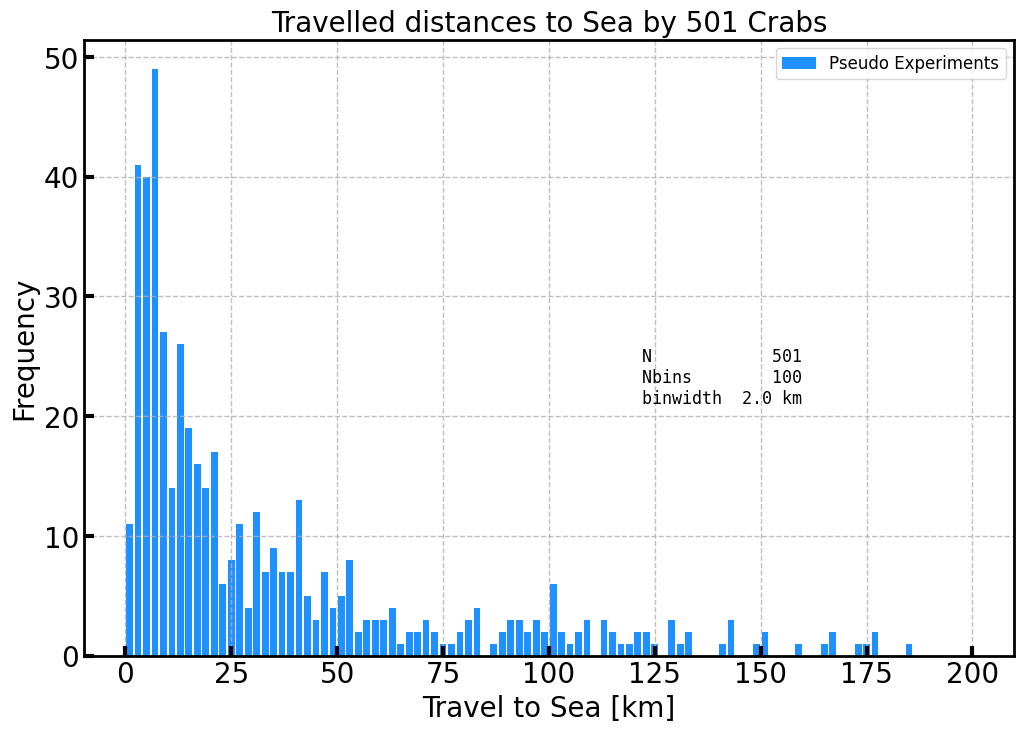

In [ ]:
def pseudo501():
    PSEUDO_SIZE = 501
    travelToSea = repeatPseudoExp(PSEUDO_SIZE)
    histoTravelToSea(travelToSea)
pseudo501()
## 21.8 sec

* Ex3(c) simulate 20 crabs

In [ ]:
def readData():
    filename = 'resources/crabs_initial.data'
    df = pd.read_csv(filename, sep=' ', header=None)
    df = pd.DataFrame(df.astype(float))
    df.columns = ['X', 'Y']
    df = df.apply(lambda x: x * 1000)
    return df

In [ ]:
class Crabs:
    ## ------------- CTOR --------------- ##
    def __init__(self, initial_df):
        self.initial_df = initial_df
        self.crabs = self.__makeCrabs()
        self.passedDays = 0
    
    def __makeCrabs(self):
        crabs = []
        for _, row in self.initial_df.iterrows():
            crabs.append(Crab([row['X'], row['Y']]))
        return crabs
    
    ## ------------- public getters --------------- ##
    def getCrabs(self):
        return self.crabs
    
    def getPopulation(self):
        alive_crabs = [crab for crab in self.crabs if crab.getIsAlive()]
        return len(alive_crabs)
        
    def getDays(self):
        return self.passedDays
    
    ## ------------- main executors --------------- ##
    def evolve(self, days):
        for _ in range(days):
            for crab in self.crabs:
                crab.walk()
                theOtherCrabs = self.__getTheOtherCrabs(crab)
                if self.__isIntruded(crab, theOtherCrabs):
                    competitor = self.__getCompetitor(crab, theOtherCrabs)
                    self.__handleCombat(crab, competitor)
            self.passedDays += 1
    
    def evolveWithPopulationLimit(self, thresholdPopulation):
        while self.getPopulation() > thresholdPopulation:
            self.evolve(1)

    ## ------------- private getters --------------- ##
    def __getTheOtherCrabs(self, crab):
        theOtherCrabs = [c for c in self.crabs if c != crab and c.getIsAlive()]
        return theOtherCrabs
    
    def __isIntruded(self, crab, theOtherCrabs):
        TERRITORY = 175
        for other_crab in theOtherCrabs:
            between = getDistanceBetween(crab.position, other_crab.position)
            if between is not None and between < TERRITORY:  # Check if distance is not None
                return True
        return False
    
    def __getCompetitor(self, crab, theOtherCrabs):
        TERRITORY = 175
        min_between = 1e6
        competitor = None
        for other_crab in theOtherCrabs:
            between = getDistanceBetween(crab.position, other_crab.position)
            if between < TERRITORY and between < min_between:
                min_between = between
                competitor = other_crab
        return competitor
    
    ## ------------- private handlers --------------- ##
    def __handleCombat(self, crab, competitor):
        mass1, mass2 = crab.getMass(), competitor.getMass()
        if mass1 > mass2:
            p_devour = mass1**2 / (mass1**2 + mass2**2)
        else:
            p_devour = mass2**2 / (mass1**2 + mass2**2)
        p_challenge = np.random.uniform(0, 1)
        
        if p_devour > p_challenge:
            if mass1 > mass2:
                predator, prey = crab, competitor
            else:
                predator, prey = competitor, crab    
            predator.devour(prey.mass)
            prey.eaten()

In [ ]:
def getStats(crabs, verbose = False):
    alives = [crab for crab in crabs if crab.getIsAlive()]
    masses = [crab.mass for crab in alives]
    N_alives = len(alives)
    maxMass = max(masses)
    totalMass = sum(masses)
    if verbose:
        print(f'Number of alive crabs: {N_alives}')
        print(f'Maximum mass: {maxMass:.1f} kg')
    return N_alives, maxMass, totalMass

In [ ]:
def showMaker(Z, X, Y, crabs):
    fig, ax = plt.subplots(figsize=(11, 8))
    cmap = ListedColormap(CMAP)

    # Using pcolormesh; X, Y, and Z dimensions must all match.
    c = ax.pcolormesh(X, Y, Z, cmap=cmap, shading='auto')
    
    half = len(crabs) // 2
    
    # Plot the first half of crabs with dashed lines
    for i, crab in enumerate(crabs[:half]):
        positions = crab.getHistory()
        positions_x, positions_y = zip(*positions)
        # Filter out positions of eaten crabs (set to None)
        positions_x = [x for x in positions_x if x is not None]
        positions_y = [y for y in positions_y if y is not None]
        markersize = (crab.getMass() + 0.5) * 1.5
        ax.plot(positions_x, positions_y, marker='.', linestyle='--', linewidth=1, markersize=markersize, label=f'crab{i+1}')

    # Plot the rest of the crabs with solid lines
    for i, crab in enumerate(crabs[half:]):
        positions = crab.getHistory()
        positions_x, positions_y = zip(*positions)
        # Filter out positions of eaten crabs (set to None)
        positions_x = [x for x in positions_x if x is not None]
        positions_y = [y for y in positions_y if y is not None]
        markersize = (crab.getMass() + 0.5) * 1.5
        ax.plot(positions_x, positions_y, marker='.', linestyle='-', linewidth=1, markersize=markersize, label=f'crab{half + i + 1}')

    ax.set_xlabel('x(m)')
    ax.set_ylabel('y(m)')
    ax.set_title('Positional Evolution of 20 crabs for 200 days')
    # plt.colorbar(c, ax=ax)
    N_alives, maxMass, totalMass = getStats(crabs)
    d = {'Survivors ': N_alives, 
         'Max mass  ': f'{maxMass:.1f}kg', 
         'Total mass': f'{totalMass:.1f}kg'
         }
    add_text_to_ax(0.66, 0.15, nice_string_output(d, 0), ax, fontsize=12)


    ax.legend()


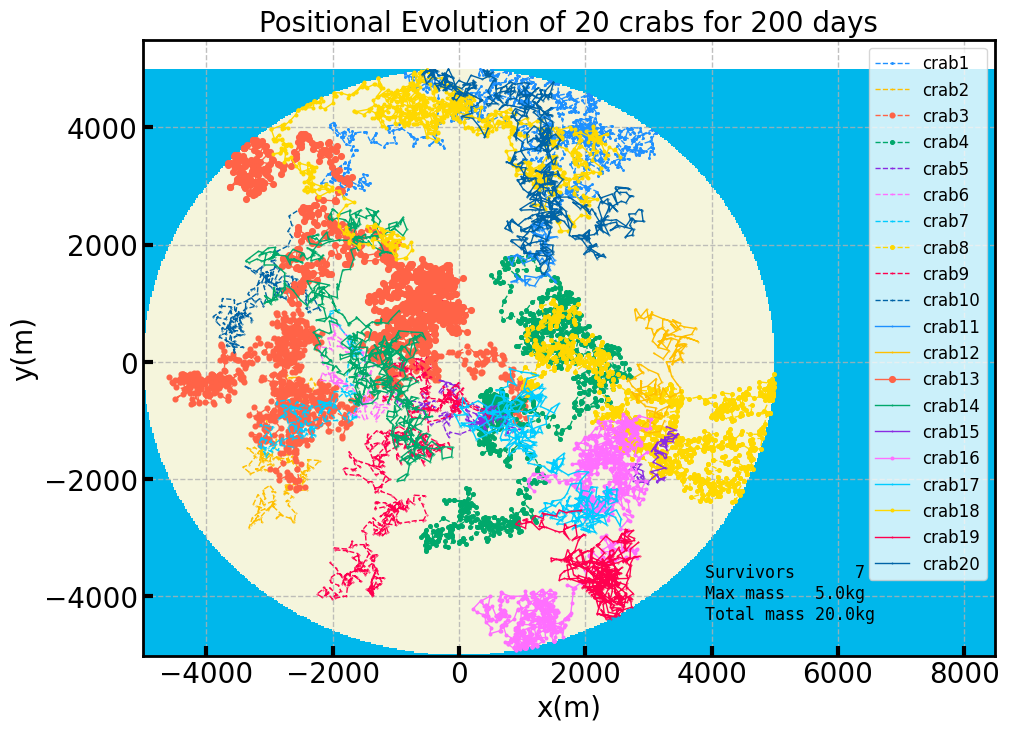

In [ ]:
def crabsShell(N=200):
    crabs = Crabs(readData())
    crabs.evolve(N)
    crabs = crabs.getCrabs()
    showMaker(ISLAND, ISLAND_X, ISLAND_Y, crabs)
    
# crabsShell()
crabsShell(1000)
# 10.9 sec

In [ ]:
def buildHistoTexts(title, label, binwidth, 
                    d_text_x, d_text_y, 
                    xlabel = 'X', ylabel = 'Y', 
                    rotation = 0, density = False,
                    additional_d = {}):
    texts = {}
    texts['title'] = title
    texts['label'] = label
    texts['binwidth'] = binwidth
    texts['d_x'] = d_text_x
    texts['d_y'] = d_text_y
    texts['xlabel'] = xlabel
    texts['ylabel'] = ylabel
    texts['rotation'] = rotation
    texts['density'] = density
    texts['add_d'] = additional_d
    return texts

In [ ]:
def plotHisto(data, texts):
    title = texts['title']
    label = texts['label']
    binwidth = texts['binwidth']
    xlabel = texts['xlabel']
    ylabel = texts['ylabel']
    d_text_x = texts['d_x']
    d_text_y = texts['d_y']
    rotation = texts['rotation']
    density = texts['density']
        
    fig, ax = plt.subplots(figsize=(12, 9))
    bins, counts, bin_centers, x_centres = getHistoParamWithBinWidth(data, binwidth)
    Nbins = len(bins)
    _, _, patches = ax.hist(data, bins=bins, rwidth=0.9, label=label)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_xticks(bin_centers)
    ax.set_xticklabels([f'{int(label)}' for label in bin_centers], rotation=rotation)
    ax.legend()

    # display the count of each bar on the top
    for patch, count in zip(patches, counts):
         height = patch.get_height()
         ax.text(patch.get_x() + patch.get_width() / 2.,
                  height, f'{count:.0f}', 
                  ha='center', va='bottom', 
                  fontsize=16)
    add_d = texts['add_d']
    d = {'N': len(data), 
         'Nbins': Nbins, 
         'binwidth': f'{binwidth:.2f}',
         'Mean': f'{np.mean(data):.1f}',
         'Median': f'{np.median(data):.1f}',
         'Std': f'{np.std(data):.1f}',
         
         }
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(d_text_x, d_text_y, text, ax, fontsize=12, color='k')

In [ ]:
def core200DaysExp(EXP_SIZE):
    N_alives = np.zeros(EXP_SIZE)
    maxMass = np.zeros(EXP_SIZE)
    totalMass = np.zeros(EXP_SIZE)
    NDAYS = 200
    for i in tqdm(range(EXP_SIZE)):
        crabs = Crabs(readData())
        crabs.evolve(NDAYS)
        N_alives[i], maxMass[i], totalMass[i] = getStats(crabs.getCrabs())
    
    return N_alives, maxMass, totalMass

In [ ]:
# N_alives, maxMass, totalMass = core200DaysExp(501)
# Mac 5m 22sec = 322 sec 
# Win : 43 sec

 13%|█▎        | 66/501 [00:25<03:01,  2.40it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x109868700>>
Traceback (most recent call last):
  File "/Users/yhjo/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 23%|██▎       | 115/501 [00:38<01:53,  3.40it/s]

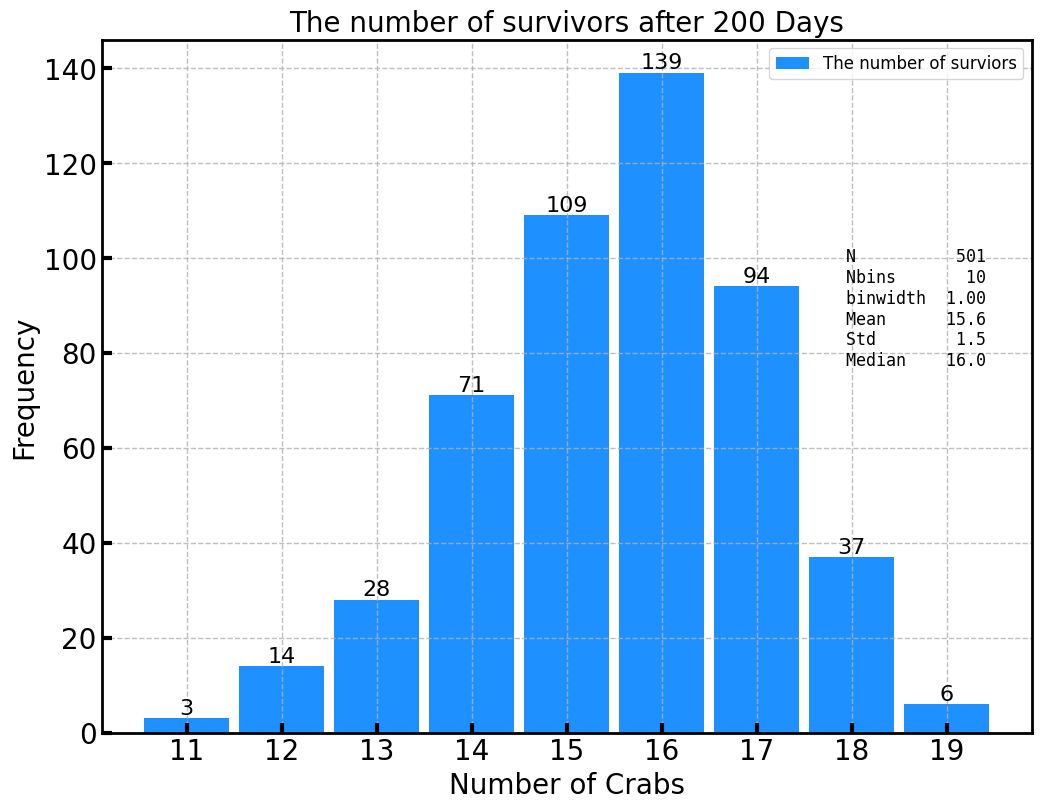

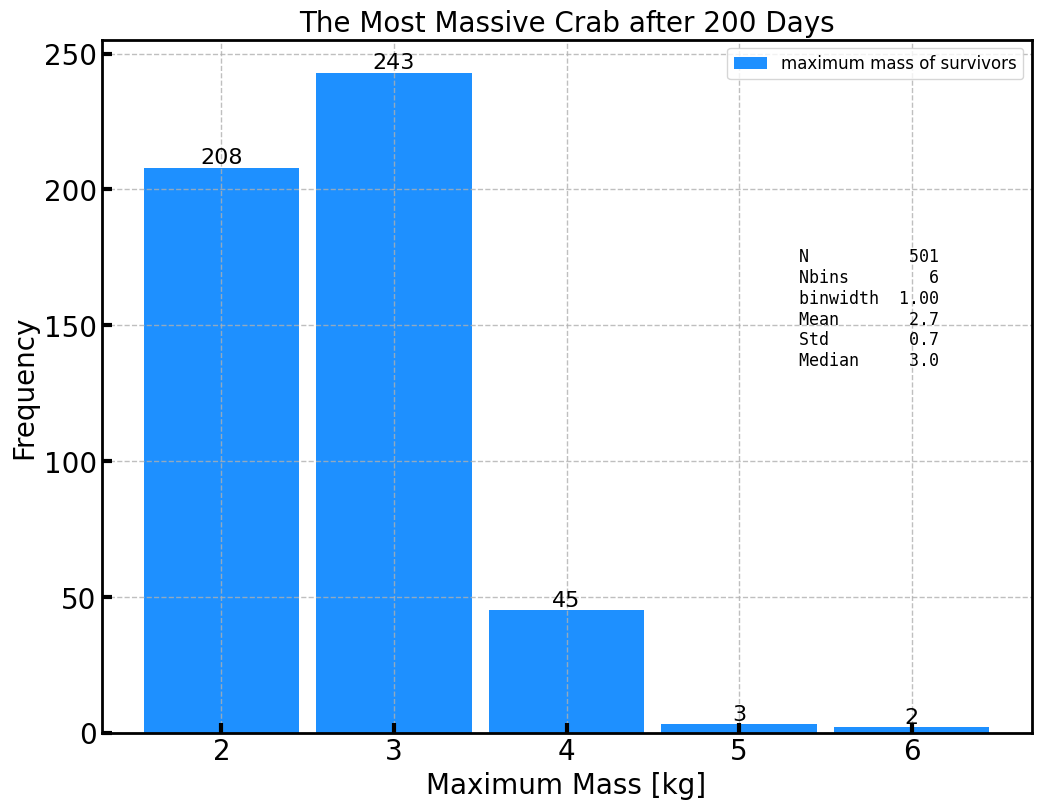

In [ ]:
def plot200DaysExp(N_alives, maxMass):
    histoText_alive = buildHistoTexts('The number of survivors after 200 Days',
                                    'The number of surviors',
                                    1.0,
                                    0.8,
                                    0.7,
                                    'Number of Crabs',
                                    'Frequency')
    plotHisto(N_alives, histoText_alive)
    histoText_maxMass = buildHistoTexts('The Most Massive Crab after 200 Days',
                                    'maximum mass of survivors',
                                    1.0,
                                    0.75,
                                    0.7,
                                    'Maximum Mass [kg]',
                                    'Frequency')
    plotHisto(maxMass, histoText_maxMass)
plot200DaysExp(N_alives, maxMass)


In [ ]:
def core10survivors(EXP_SIZE):
    N_days = np.zeros(EXP_SIZE)
    for i in tqdm(range(EXP_SIZE)):
        crabs = Crabs(readData())
        crabs.evolveWithPopulationLimit(10)
        N_days[i] = crabs.getDays()
    return N_days


In [ ]:
N_days = core10survivors(501)
# Win :2m 7sec = 127 sec

100%|██████████| 501/501 [02:09<00:00,  3.86it/s]


In [ ]:
binwidth_10survivors = 50

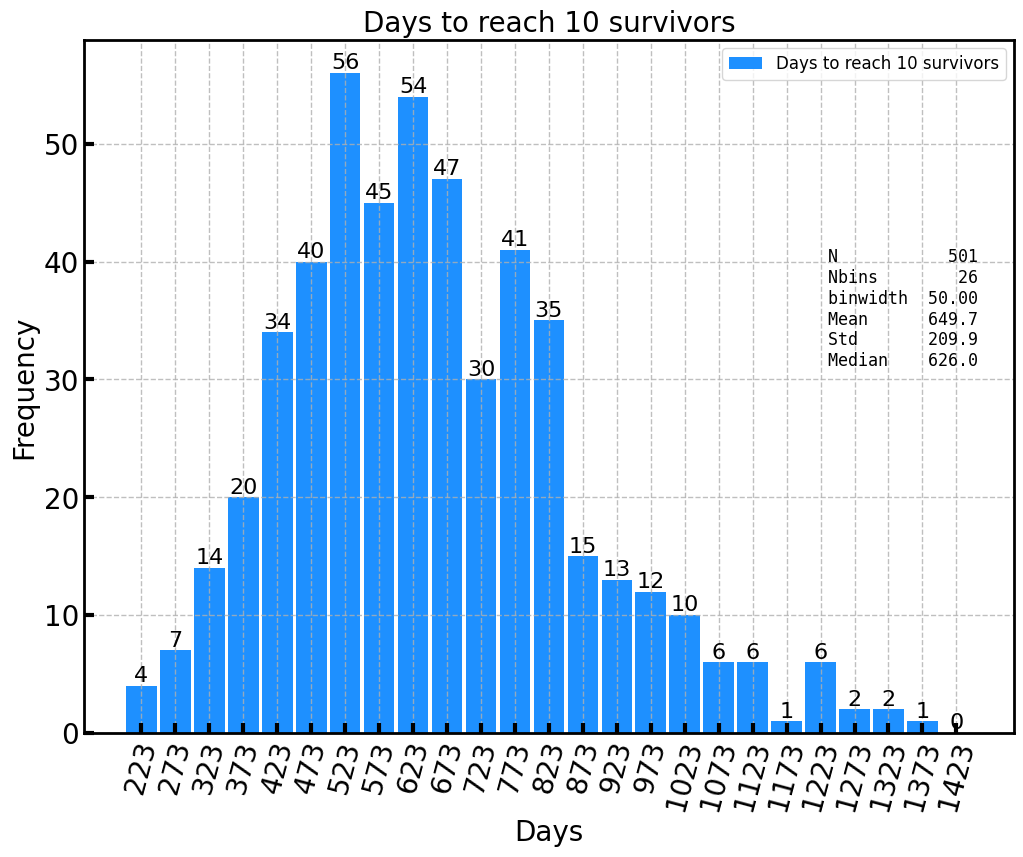

In [ ]:
def plot10survivors(N_days):
    histoText_days = buildHistoTexts('Days to reach 10 survivors',
                                    'Days to reach 10 survivors',
                                    binwidth_10survivors, # binwidth
                                    0.8,
                                    0.7,
                                    'Days',
                                    'Frequency',
                                    75)
    plotHisto(N_days, histoText_days)
    # print(f'Mean: {np.mean(N_days):.1f}')
plot10survivors(N_days)

In [ ]:
tailPortion = (1 - 0.6827)/2
print(f'tailPortion: {tailPortion}')

tailPortion: 0.15865


confidence interval: 449 - 840


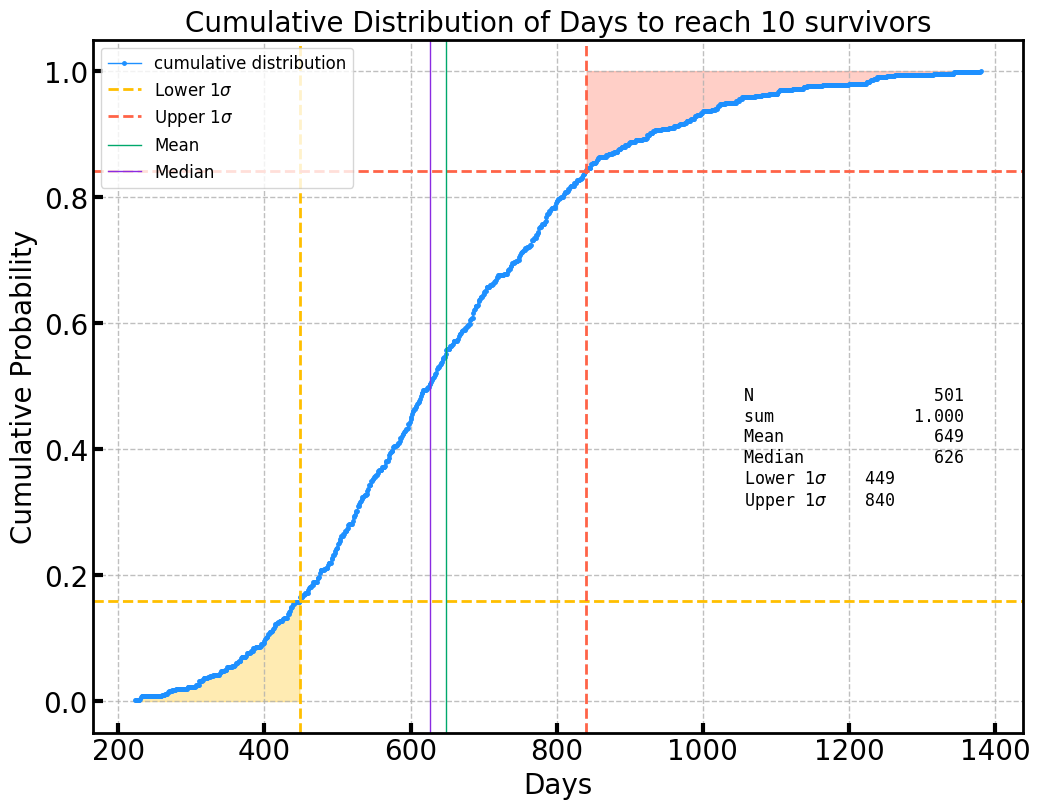

In [ ]:
def stats10survivors(data, binwidth):
    bins, counts, bin_centers, x_centres = getHistoParamWithBinWidth(data, 1, True)
    
    cumulation = np.cumsum(counts)
    lower_oneSig = np.argmax(cumulation > tailPortion)
    upper_oneSig = np.argmax(cumulation > 1 - tailPortion)

    x_low_oneSig = int(x_centres[lower_oneSig])
    x_up_oneSig = int(x_centres[upper_oneSig])
    mean = int(np.mean(data))
    median = int(np.median(data))

    fig, ax = plt.subplots(figsize=(12, 9))
    ax.plot(x_centres, cumulation, marker='.', linestyle='-', linewidth=1, markersize=5, label='cumulative distribution')
    # lower 1 sigma
    ax.axvline(x_low_oneSig, color=COLOUR[1], linestyle='--', label=f'Lower 1$\sigma$')
    ax.fill_between(x_centres, cumulation, where=(x_centres < x_low_oneSig), color=COLOUR[1], alpha=0.3)
    ax.axhline(tailPortion, color=COLOUR[1], linestyle='--')
    # upper 1 sigma
    ax.axvline(x_up_oneSig, color=COLOUR[2], linestyle='--', label=f'Upper 1$\sigma$')
    ax.axhline(1 - tailPortion, color=COLOUR[2], linestyle='--')
    ax.fill_between(x_centres, np.ones_like(x_centres), cumulation, where=(x_centres > x_up_oneSig), color=COLOUR[2], alpha=0.3)

    ax.axvline(mean, color=COLOUR[3], linestyle='-', lw = 1, label=f'Mean')
    ax.axvline(median, color=COLOUR[4], linestyle='-', lw = 1, label=f'Median')
    ax.set_title('Cumulative Distribution of Days to reach 10 survivors')
    ax.set_xlabel('Days')
    ax.set_ylabel('Cumulative Probability')
    ax.legend(loc = 'upper left')
    d = {'N              ': len(data), 
         'sum            ': f'{np.sum(counts):.3f}',
         'Mean           ': f'{mean}',
         'Median         ': f'{median}',
         'Lower 1$\sigma$': f'{x_low_oneSig}',
         'Upper 1$\sigma$': f'{x_up_oneSig}'
        }
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.7, 0.5, text, ax, fontsize=12, color='k')
    print(f'confidence interval: {x_low_oneSig} - {x_up_oneSig}')
    return mean, x_low_oneSig, x_up_oneSig
mean, x_low_oneSig, x_up_oneSig = stats10survivors(N_days, binwidth_10survivors)


In [ ]:
def finalHisto(data, texts):
    title = texts['title']
    label = texts['label']
    binwidth = texts['binwidth']
    xlabel = texts['xlabel']
    ylabel = texts['ylabel']
    d_text_x = texts['d_x']
    d_text_y = texts['d_y']
    rotation = texts['rotation']
    density = texts['density']
        
    fig, ax = plt.subplots(figsize=(12, 9))
    bins, counts, bin_centers, x_centres = getHistoParamWithBinWidth(data, binwidth)
    Nbins = len(bins)
    _, _, patches = ax.hist(data, bins=bins, rwidth=0.9, label=label)

     # lower 1 sigma
    ax.axvline(x_low_oneSig, color=COLOUR[1], lw = 2, linestyle='-', label=f'Lower 1$\sigma$')
#     ax.fill_between(x_centres, cumulation, where=(x_centres < x_low_oneSig), color=COLOUR[1], alpha=0.3)
    # upper 1 sigma
    ax.axvline(x_up_oneSig, color=COLOUR[2], lw = 2, linestyle='-', label=f'Upper 1$\sigma$')
#     ax.fill_between(x_centres, np.ones_like(x_centres), cumulation, where=(x_centres > x_up_oneSig), color=COLOUR[2], alpha=0.3)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_xticks(bin_centers)
    ax.set_xticklabels([f'{int(label)}' for label in bin_centers], rotation=rotation)
    ax.legend()

    # display the count of each bar on the top
    for patch, count in zip(patches, counts):
         height = patch.get_height()
         ax.text(patch.get_x() + patch.get_width() / 2.,
                  height, f'{count:.0f}', 
                  ha='center', va='bottom', 
                  fontsize=16)
    # add_d = texts['add_d']
    d = {'N': len(data), 
         'Nbins': Nbins, 
         'binwidth': f'{binwidth:.2f}',
         'Mean': f'{int(np.mean(data))}',
         'Median': f'{int(np.median(data))}',
         'Std': f'{np.std(data):.1f}',
            'Lower 1$\sigma$': f'{x_low_oneSig}',
            'Upper 1$\sigma$': f'{x_up_oneSig}'
            
         
         }
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(d_text_x, d_text_y, text, ax, fontsize=12, color='k')





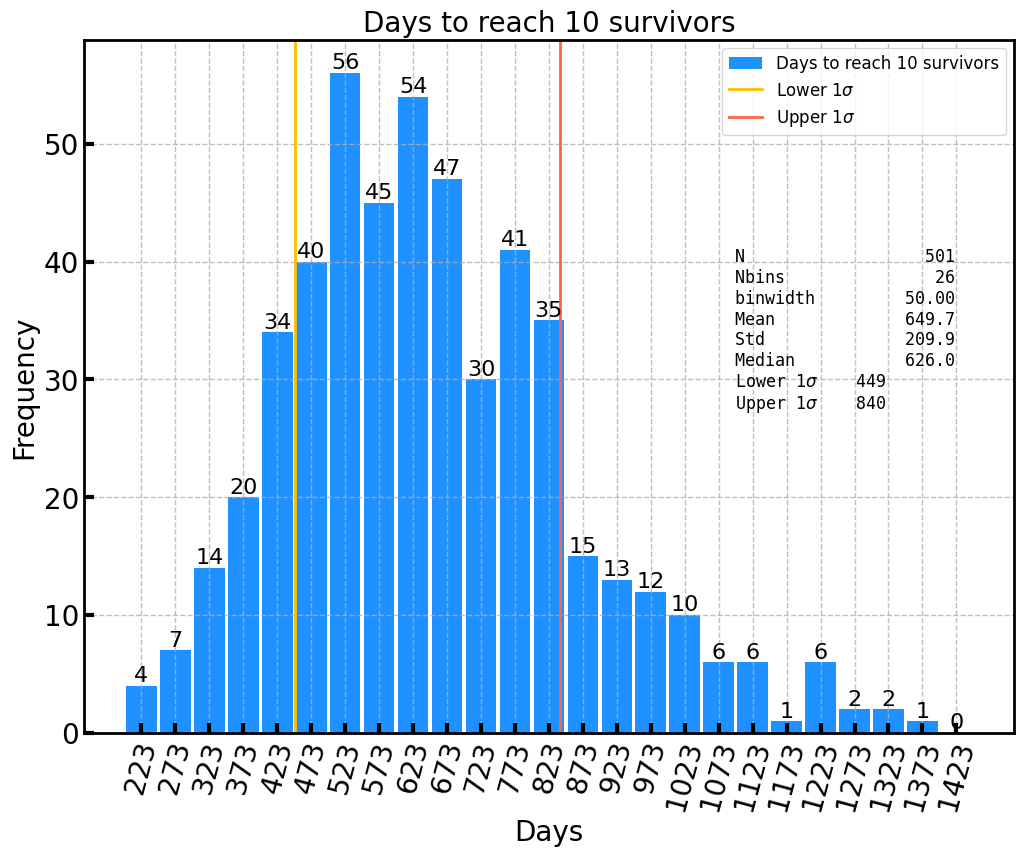

In [ ]:
def finalplot():
     histoText_days = buildHistoTexts('Days to reach 10 survivors',
                                    'Days to reach 10 survivors',
                                    binwidth_10survivors, # binwidth
                                    0.7,
                                    0.7,
                                    'Days',
                                    'Frequency',
                                    75)
     finalHisto(N_days, histoText_days)
finalplot()

In [ ]:
print(f'{mean} - {mean - x_low_oneSig} + {x_up_oneSig - mean} days')

SyntaxError: invalid syntax (274479084.py, line 1)